In [137]:
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, average_precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling1D, MaxPooling2D, LeakyReLU
from keras.initializers import RandomNormal
import keras.optimizers as opt
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import plot_model
from keras.regularizers import l2

In [2]:
data = np.load('../data/data.npy')
meta = np.load('../data/meta.npy')
print(f'data = {data.shape}')
print(f'meta = {meta.shape}')

data = (1845, 21, 77)
meta = (1845, 3)


In [3]:
X = data[:,:,:,np.newaxis]
Y = meta[:,2][:,np.newaxis].astype(int)

In [4]:
shape = X.shape
std = StandardScaler().fit(X.reshape(-1,1))
X = std.transform(X.reshape(-1,1)).reshape(shape)

In [5]:
X,Y = shuffle(X,Y)

In [6]:
x_train, x_test,  y_train, y_test  = train_test_split(X, Y, test_size = 0.2, random_state = 31)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 31)

In [7]:
print(f"train: x={x_train.shape} y={y_train.shape}")
print(f"valid: x={x_valid.shape} y={y_valid.shape}")
print(f"test : x={x_test.shape}  y={y_test.shape}")

train: x=(1107, 21, 77, 1) y=(1107, 1)
valid: x=(369, 21, 77, 1) y=(369, 1)
test : x=(369, 21, 77, 1)  y=(369, 1)


In [8]:
CHANNELS = np.array(['A1-RF', 'A2-RF', 'C3-RF', 'C4-RF', 'Cz-RF', 'F3-RF',
                     'F4-RF', 'F7-RF', 'F8-RF', 'Fp1-RF', 'Fp2-RF', 'Fz-RF',
                     'O1-RF', 'O2-RF', 'P3-RF', 'P4-RF', 'Pz-RF', 'T3-RF',
                     'T4-RF', 'T5-RF', 'T6-RF'])

def draw_peaks(data, channels = CHANNELS, peaks = None):
    d, n = data.shape
    x = list(range(n))

    plt.rcParams['figure.figsize'] = (17, 12)
    peaks = np.where(peaks == 1)[0] if peaks is not None else None
    
    for i in range(d):
        ax = plt.subplot(d, 1, i + 1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < d - 1:
            ax.spines['bottom'].set_visible(False)
        ax.plot(x, data[i])
        plt.ylabel(channels[i])
        plt.xlim((0,n))
        if peaks is not None:
            for xl in peaks:
                ax.axvline(x = xl, color='r', linestyle='--', linewidth = 1.)
    plt.show()

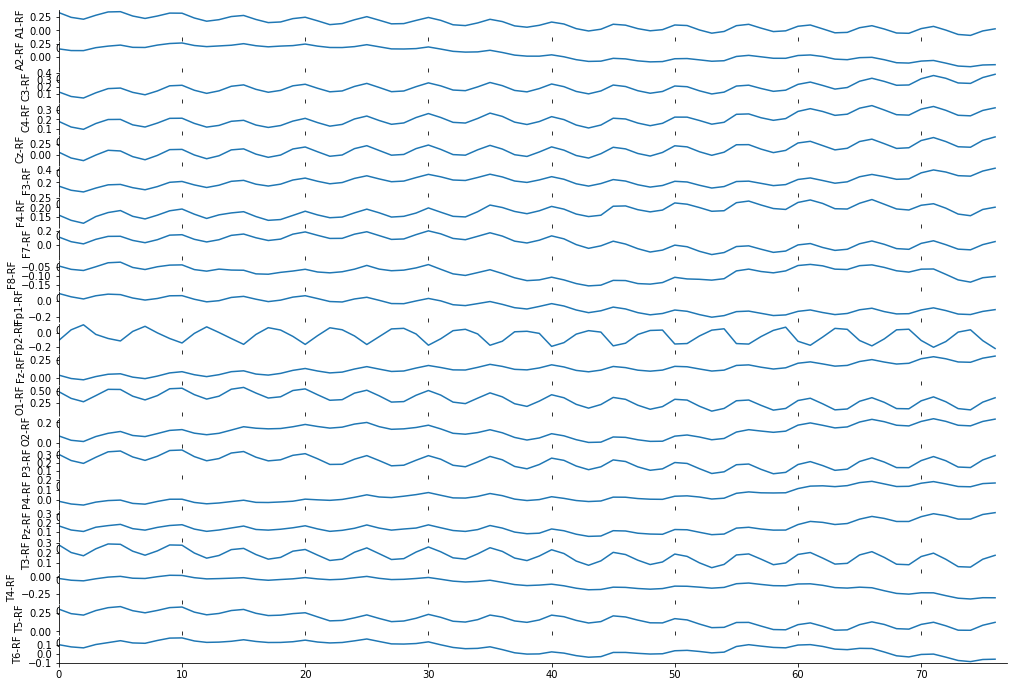

In [9]:
draw_peaks(X[0,:,:,0])

In [213]:
cnn_input = X.shape[1:]
cnn_output = Y.shape[1]
batch_size = 32

print(f"cnn_input  = {cnn_input}")
print(f"cnn_output = {cnn_output}")
print(f"batch_size = {batch_size}")

cnn_input  = (21, 77, 1)
cnn_output = 1
batch_size = 32


In [214]:
model = Sequential()

model.add(Conv2D(16, (7,7), activation = 'tanh', name = 'conv1', input_shape = cnn_input
                 ,kernel_regularizer=l2(0.005), bias_regularizer = l2(0.005)))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2), name='maxpool1'))

model.add(Conv2D(32, (5,5), activation='tanh', name='conv2'))
#                ,kernel_regularizer=l2(0.005), bias_regularizer = l2(0.005)))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), name='maxpool2'))

model.add(Conv2D(64, (3,3), activation='tanh', name='conv3'))
#                ,kernel_regularizer=l2(0.005), bias_regularizer = l2(0.005)))
#model.add(MaxPooling2D(pool_size=(2,2), strides = (1,1), name='maxpool3'))

model.add(Flatten(name='flat4'))
model.add(Dropout(0.10, name='drop4'))
model.add(Dense(1024, activation='tanh', name='dense4'))

model.add(Dense(cnn_output, activation='sigmoid', name='softmax'))

In [215]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 15, 71, 16)        800       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 7, 35, 16)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 31, 32)         12832     
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 29, 64)         18496     
_________________________________________________________________
flat4 (Flatten)              (None, 1856)              0         
_________________________________________________________________
drop4 (Dropout)              (None, 1856)              0         
_________________________________________________________________
dense4 (Dense)               (None, 1024)              1901568   
__________

In [216]:
optim = opt.SGD(lr = 0.001, decay = 1e-6, momentum = 0.5, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 30, verbose = 1, restore_best_weights = True)

In [217]:
log = model.fit(x_train, y_train, batch_size = batch_size, epochs = 300, 
          verbose = 2, validation_data=(x_valid, y_valid), callbacks = [ es ])

Train on 1107 samples, validate on 369 samples
Epoch 1/300
 - 1s - loss: 0.6716 - acc: 0.6242 - val_loss: 0.6445 - val_acc: 0.6721
Epoch 2/300
 - 0s - loss: 0.6272 - acc: 0.7019 - val_loss: 0.6202 - val_acc: 0.6694
Epoch 3/300
 - 0s - loss: 0.6050 - acc: 0.7028 - val_loss: 0.6062 - val_acc: 0.6721
Epoch 4/300
 - 0s - loss: 0.5895 - acc: 0.7028 - val_loss: 0.5909 - val_acc: 0.6748
Epoch 5/300
 - 0s - loss: 0.5753 - acc: 0.7055 - val_loss: 0.5768 - val_acc: 0.6775
Epoch 6/300
 - 0s - loss: 0.5623 - acc: 0.7109 - val_loss: 0.5621 - val_acc: 0.6802
Epoch 7/300
 - 0s - loss: 0.5463 - acc: 0.7218 - val_loss: 0.5450 - val_acc: 0.6856
Epoch 8/300
 - 0s - loss: 0.5294 - acc: 0.7272 - val_loss: 0.5277 - val_acc: 0.7182
Epoch 9/300
 - 0s - loss: 0.5111 - acc: 0.7543 - val_loss: 0.5114 - val_acc: 0.7209
Epoch 10/300
 - 0s - loss: 0.4922 - acc: 0.7642 - val_loss: 0.4957 - val_acc: 0.7453
Epoch 11/300
 - 0s - loss: 0.4748 - acc: 0.7814 - val_loss: 0.4800 - val_acc: 0.7507
Epoch 12/300
 - 0s - loss: 

Epoch 97/300
 - 0s - loss: 0.1690 - acc: 0.9440 - val_loss: 0.2397 - val_acc: 0.9079
Epoch 98/300
 - 0s - loss: 0.1638 - acc: 0.9458 - val_loss: 0.2645 - val_acc: 0.9024
Epoch 99/300
 - 0s - loss: 0.1647 - acc: 0.9476 - val_loss: 0.2436 - val_acc: 0.9133
Epoch 100/300
 - 0s - loss: 0.1627 - acc: 0.9458 - val_loss: 0.2493 - val_acc: 0.9106
Epoch 101/300
 - 0s - loss: 0.1623 - acc: 0.9503 - val_loss: 0.2580 - val_acc: 0.9079
Epoch 102/300
 - 0s - loss: 0.1621 - acc: 0.9485 - val_loss: 0.2465 - val_acc: 0.9133
Epoch 103/300
 - 0s - loss: 0.1589 - acc: 0.9530 - val_loss: 0.2864 - val_acc: 0.8997
Epoch 104/300
 - 0s - loss: 0.1571 - acc: 0.9503 - val_loss: 0.2487 - val_acc: 0.9024
Epoch 105/300
 - 0s - loss: 0.1609 - acc: 0.9458 - val_loss: 0.2442 - val_acc: 0.9079
Epoch 106/300
 - 0s - loss: 0.1585 - acc: 0.9449 - val_loss: 0.2415 - val_acc: 0.9024
Epoch 107/300
 - 0s - loss: 0.1578 - acc: 0.9485 - val_loss: 0.2614 - val_acc: 0.9079
Epoch 108/300
 - 0s - loss: 0.1604 - acc: 0.9467 - val_lo

Epoch 193/300
 - 0s - loss: 0.0919 - acc: 0.9756 - val_loss: 0.2263 - val_acc: 0.9322
Epoch 194/300
 - 0s - loss: 0.0931 - acc: 0.9747 - val_loss: 0.2131 - val_acc: 0.9133
Epoch 195/300
 - 0s - loss: 0.0958 - acc: 0.9765 - val_loss: 0.2135 - val_acc: 0.9214
Epoch 196/300
 - 0s - loss: 0.0908 - acc: 0.9756 - val_loss: 0.1952 - val_acc: 0.9268
Epoch 197/300
 - 0s - loss: 0.0919 - acc: 0.9765 - val_loss: 0.1966 - val_acc: 0.9214
Epoch 198/300
 - 0s - loss: 0.0922 - acc: 0.9774 - val_loss: 0.2116 - val_acc: 0.9295
Epoch 199/300
 - 0s - loss: 0.0910 - acc: 0.9747 - val_loss: 0.2283 - val_acc: 0.9187
Epoch 200/300
 - 0s - loss: 0.0936 - acc: 0.9738 - val_loss: 0.2094 - val_acc: 0.9350
Epoch 201/300
 - 0s - loss: 0.0872 - acc: 0.9819 - val_loss: 0.1985 - val_acc: 0.9241
Epoch 202/300
 - 0s - loss: 0.0867 - acc: 0.9801 - val_loss: 0.2225 - val_acc: 0.9241
Epoch 203/300
 - 0s - loss: 0.0874 - acc: 0.9720 - val_loss: 0.2366 - val_acc: 0.9214
Epoch 204/300
 - 0s - loss: 0.0828 - acc: 0.9828 - val

In [218]:
result = model.evaluate(x_test, y_test)
print('Testing:')
print('\n'.join('{} = {}'.format(*k) for k in zip(model.metrics_names, result)))

369/369 [==============================] - 0s 43us/step
Testing:
loss = 0.21388625799801939
acc = 0.9403794042786285


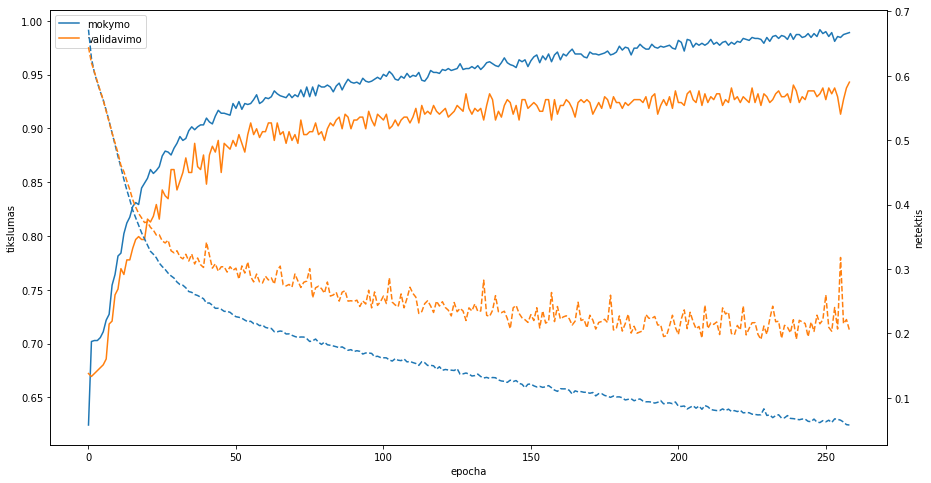

In [219]:
plt.rcParams['figure.figsize'] = (15, 8)

plt.plot(log.history['acc'], label = 'mokymo')
plt.plot(log.history['val_acc'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend() #['mokymo', 'testavimo'])

ax2 = plt.twinx()
ax2.plot(log.history['loss'], '--', label = 'mokymo')
ax2.plot(log.history['val_loss'], '--', label = 'validavimo')
ax2.set_ylabel('netektis')
#plt.title('model accuracy')
plt.show()

#joblib.dump(model, os.path.join(OUTPUT_FOLDER,f'nn_{h}_veg.pkl'))

In [220]:
confusion_matrix(y_test, model.predict_classes(x_test))

array([[242,   9],
       [ 13, 105]])

In [221]:
f1_score(y_test, model.predict_classes(x_test))

0.9051724137931034

In [222]:
roc_auc_score(y_test, model.predict(x_test))

0.9762306705381864

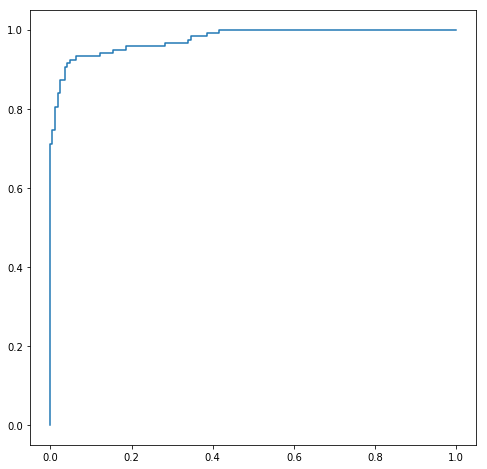

In [223]:
plt.rcParams['figure.figsize'] = (8, 8)
roc = roc_curve(y_test, model.predict(x_test))
plt.plot(roc[0],roc[1])
plt.show()

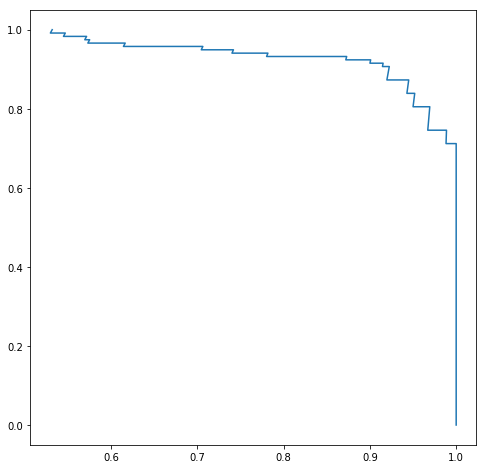

In [224]:
plt.rcParams['figure.figsize'] = (8, 8)
prc = precision_recall_curve(y_test, model.predict(x_test))
plt.plot(prc[0],prc[1])
plt.show()

In [225]:
average_precision_score(y_test, model.predict(x_test))

0.9640671678824373

In [226]:
precision_score(y_test, model.predict_classes(x_test))

0.9210526315789473

In [227]:
recall_score(y_test, model.predict_classes(x_test))

0.8898305084745762

## Visualization of activations

In [228]:
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = Model(inputs = model.input, outputs = layer_outputs)

In [229]:
test_case = x_test[0][np.newaxis,:]

In [230]:
activations = activation_model.predict(test_case)

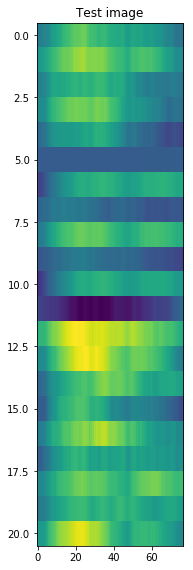

In [231]:
scale = 1. / 8
plt.figure(figsize=(scale * test_case.shape[1],
                    scale * test_case.shape[2]))
plt.title('Test image')
plt.grid(False)
plt.imshow(np.reshape(test_case, test_case.shape[1:3]), aspect='auto', cmap='viridis')
plt.show()

In [232]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)
layer_names

['conv1', 'maxpool1', 'conv2', 'conv3', 'flat4', 'drop4', 'dense4', 'softmax']

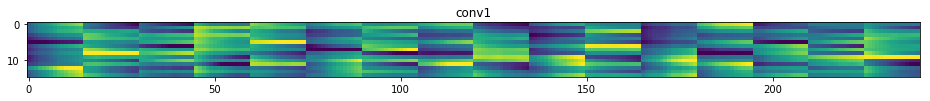

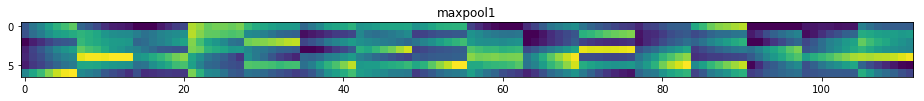

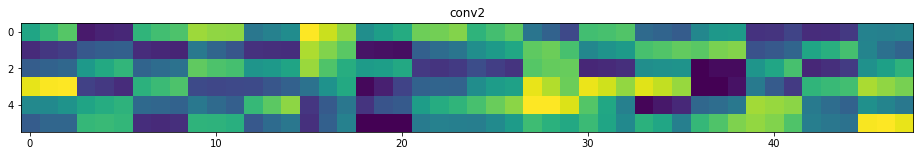

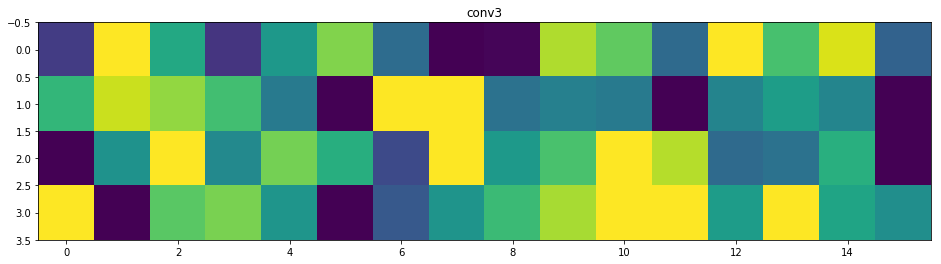

In [233]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image[:size, :size]
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
#    break